## Setup


In [1]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics
import sklearn

from matplotlib import pyplot as plt

from glob import glob
import os
import shutil

import pandas as pd
from tqdm.notebook import tqdm

import cv2

import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

### Download the Dataset

https://drive.google.com/drive/folders/198iMVj0xTOU7-FEPhuopc2wXGnKpSCW1?usp=sharing

In [3]:
dataset_folder = 'training'
image_files = glob(os.path.join(dataset_folder,'*/*.png'))
image_files = pd.Series(image_files).str.rsplit('/',n=1,expand=True)
image_files.columns=['Folder','Image Index']

images = pd.read_csv(os.path.join(dataset_folder,'Data_Entry_2017.csv'))
images = image_files.merge(images.join(images['Finding Labels'].str.get_dummies()),on='Image Index',how='left')
dataset = images[['Folder', 'Image Index', 'Pneumonia']].copy()

dataset.rename(columns={'Pneumonia':'label'},inplace=True)
num_classes = dataset.label.nunique()

In [4]:
dataset

Folder       Image Index  label
0     drive/MyDrive/training/1  00001736_010.png      1
1     drive/MyDrive/training/1  00027706_010.png      1
2     drive/MyDrive/training/1  00004526_013.png      1
3     drive/MyDrive/training/1  00007007_016.png      1
4     drive/MyDrive/training/1  00017055_001.png      1
...                        ...               ...    ...
2795  drive/MyDrive/training/0  00024534_000.png      0
2796  drive/MyDrive/training/0  00023732_000.png      0
2797  drive/MyDrive/training/0  00012086_000.png      0
2798  drive/MyDrive/training/0  00018144_002.png      0
2799  drive/MyDrive/training/0  00016472_004.png      0

[2800 rows x 3 columns]

In [11]:
activation = 'relu'
epoch_toptrain = 20
total_epochs = 100
batchsize = 16

val_freq = 5
val_split = 0.2

imagesize=(256,256,3)

lr = 0.001

seed = 123
shuffle = True
layer_map = {1:'grayscale',3:'rgb'}

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_folder,
                                                       color_mode=layer_map[imagesize[2]],
                                                       image_size=imagesize[:2],
                                                       shuffle=shuffle,
                                                       label_mode='categorical',
                                                       validation_split=val_split,
                                                       batch_size=batchsize,
                                                       seed=seed,
                                                       subset='training')
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_folder,
                                                       color_mode=layer_map[imagesize[2]],
                                                       image_size=imagesize[:2],
                                                       shuffle=shuffle,
                                                       label_mode='categorical',
                                                       validation_split=val_split,
                                                       batch_size=batchsize,
                                                       seed=seed,
                                                       subset='validation')

Found 2800 files belonging to 2 classes.
Using 2240 files for training.
Found 2800 files belonging to 2 classes.
Using 560 files for validation.


In [ ]:
efficientnet = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False,
                                                             weights='imagenet',
                                                             input_shape=imagesize,
                                                             pooling='max')

x = efficientnet.output
x = tf.keras.layers.Dense(1024, activation='relu')(x)

predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

net = tf.keras.Model(inputs = efficientnet.input, outputs = predictions)

for layer in efficientnet.layers:
    layer.trainable = False

net.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

net.summary()

In [ ]:
checkpoint_filepath='checkpoint/efficientnet_stage1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

net.fit(train_ds,
         validation_data=val_ds,
         epochs=epoch_toptrain,
         validation_freq=val_freq,
         callbacks=[model_checkpoint_callback],
         verbose=1)

In [20]:
imagesize_top = (224,224,3)

train_ds_top = tf.keras.utils.image_dataset_from_directory(dataset_folder,
                                                       color_mode=layer_map[imagesize_top[2]],
                                                       image_size=imagesize_top[:2],
                                                       shuffle=shuffle,
                                                       label_mode='categorical',
                                                       validation_split=val_split,
                                                       batch_size=batchsize,
                                                       seed=seed,
                                                       subset='training')
val_ds_top = tf.keras.utils.image_dataset_from_directory(dataset_folder,
                                                       color_mode=layer_map[imagesize_top[2]],
                                                       image_size=imagesize_top[:2],
                                                       shuffle=shuffle,
                                                       label_mode='categorical',
                                                       validation_split=val_split,
                                                       batch_size=batchsize,
                                                       seed=seed,
                                                       subset='validation')

Found 2800 files belonging to 2 classes.
Using 2240 files for training.
Found 2800 files belonging to 2 classes.
Using 560 files for validation.


In [21]:
efficientnet_top = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = True,
                                                                          weights='imagenet')

x = efficientnet_top.get_layer('top_dropout').output
x = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

net_top = tf.keras.Model(inputs = efficientnet_top.input, outputs = x)

for layer in efficientnet_top.layers[:267]:
    layer.trainable = False

net_top.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

net_top.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  0          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

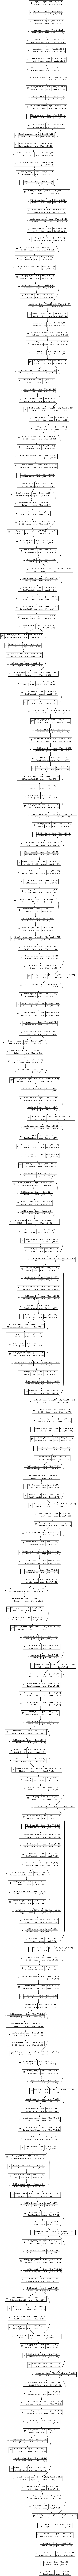

In [25]:
tf.keras.utils.plot_model(net_top, to_file= 'model.png', show_shapes = True, show_layer_names = True, show_trainable = True, show_layer_activations = True)

In [22]:
checkpoint_filepath='checkpoint/efficientnet_stage1_top'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

net_top.fit(train_ds_top,
            validation_data=val_ds_top,
            epochs=epoch_toptrain,
            validation_freq=val_freq,
            callbacks=[model_checkpoint_callback],
            verbose=1)

Epoch 1/20
140/140 [==============================] - 118s 806ms/step - loss: 0.6213 - accuracy: 0.6723
Epoch 2/20
140/140 [==============================] - 117s 818ms/step - loss: 0.5337 - accuracy: 0.7469
Epoch 3/20
140/140 [==============================] - 114s 794ms/step - loss: 0.4932 - accuracy: 0.7688
Epoch 4/20
140/140 [==============================] - 114s 792ms/step - loss: 0.4622 - accuracy: 0.7920
Epoch 5/20
140/140 [==============================] - 114s 793ms/step - loss: 0.4170 - accuracy: 0.8121
Epoch 6/20
140/140 [==============================] - 112s 783ms/step - loss: 0.4044 - accuracy: 0.8201
Epoch 7/20
140/140 [==============================] - 114s 797ms/step - loss: 0.3654 - accuracy: 0.8473
Epoch 8/20
140/140 [==============================] - 113s 787ms/step - loss: 0.3276 - accuracy: 0.8625
Epoch 9/20
140/140 [==============================] - 114s 800ms/step - loss: 0.3166 - accuracy: 0.8759
Epoch 10/20
140/140 [==============================] - 132s 926m

In [27]:
for i, layer in enumerate(net_top.layers):
   print(i, layer.name)

0 input_6
1 rescaling_5
2 normalization_5
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [ ]:
for layer in net_top.layers[:252]:
    layer.trainable = False

for layer in net_top.layers[252:]:
    layer.trainable = True

net_top.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

checkpoint_filepath='checkpoint/efficientnet_stage2_top'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

net_top.fit(train_ds_top,
            validation_data=val_ds_top,
            epochs=total_epochs-epoch_toptrain,
            validation_freq=val_freq,
            callbacks=[model_checkpoint_callback],
            verbose=1)

Epoch 1/80
140/140 [==============================] - 116s 807ms/step - loss: 0.1071 - accuracy: 0.9603
Epoch 2/80
140/140 [==============================] - 117s 815ms/step - loss: 0.0986 - accuracy: 0.9679
Epoch 3/80
140/140 [==============================] - 117s 816ms/step - loss: 0.0905 - accuracy: 0.9696
Epoch 4/80
140/140 [==============================] - 118s 822ms/step - loss: 0.0856 - accuracy: 0.9710
Epoch 5/80
140/140 [==============================] - 114s 799ms/step - loss: 0.0973 - accuracy: 0.9625
Epoch 6/80
140/140 [==============================] - 118s 816ms/step - loss: 0.0892 - accuracy: 0.9701
Epoch 7/80
140/140 [==============================] - 115s 803ms/step - loss: 0.0767 - accuracy: 0.9732
Epoch 8/80
140/140 [==============================] - 116s 808ms/step - loss: 0.0843 - accuracy: 0.9692
Epoch 9/80
140/140 [==============================] - 115s 805ms/step - loss: 0.0700 - accuracy: 0.9777
Epoch 10/80
140/140 [==============================] - 135s 939m